#### This notebook addresses questions 1, 2, and 17

#### Requirements
* comments.csv -- This is the data set of 206,606 comments, which all include at least one hate term, retrieved from Reddit in January 2022.
* unfiltered_sample.csv -- This is a data set of 46,274 comments retrieved without a filter from Reddit in January 2022, the same time period as the comments that include hate terms.
* packages: pandas, scipy stats, altair, math, and numpy

#### Creates
* RQ1.csv, RQ1_long.csv, RQ2_gender_median.csv, and RQ17_davidson_median.csv
for use in visualizations

In [35]:
import pandas as pd
import scipy.stats as stats
from scipy.stats import chisquare
from scipy.stats import chi2_contingency
import numpy as np
import math
import altair as alt
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
from scipy.stats.mstats import kruskal


#### Statistics result note
Many of the results of statistical tests are noted as 0.0. I was concerned that the tests were not being run properly, so I checked what was going in to the tests and used other samples to see whether the tests would return something other than 0.0. I eventually learned that very small numbers below a threshold -- so small as to be very close to zero -- are returned as 0.0. 

The primary dataset is so large (206,606 rows) that very small p-values are possible.

## Question 1
How is toxic speech related to gendered speech?

#### Operationalized question:
What percentage of Reddit comments that are predicted to be toxic include:
* male pronouns or identifiers (e.g., "guy")?
* female pronouns or identifiers (e.g., "gal")?
* both?
* not gendered speech?

Compare the genders identified in comments with toxic language to the genders identified identified in comments in a reference corpus that is not filtered to include the hate terms.

#### Hypotheses:
A higher percentage of comments categorized as toxic speech will have female identifiers than male identifiers or no gendered identifiers.

Toxic comments will have a higher percentage of comments with female identifiers than will a sample that is not filtered to include only toxic comments.

#### Results:
A chi-square test showed that the frequency of comments does not have the expected distribution, Chi-square post-hoc analyses showed that each gender category (female, male, both, neither) is significantly (p < 0.001) different from the expected frequencies of the other gender categories. 

Comments with female identifiers (e.g., "she", "woman") comprise 70% of our toxic language corpus. Comments with only female identifiers were significantly (p < 0.001) more prevalent than all other gender categories.

Only 8% of the comments in a sample of Reddit comments retrieved without filtering for the hate terms have only female identifiers . 

Toxic comments with female identifiers are significantly higher (p < 0.001) than would be expected if the gender in the comments was not affected by the presence of toxic language.

#### Prepare dataframe

In [36]:
comments = pd.read_csv('../data/processed/comments.csv')
display(comments.head(2))
display(comments['gender'].unique())
column_names = list(comments.columns)
display(column_names)

,all_awardings,author,author_flair_type,author_fullname,author_premium,body,body_sha1,controversiality,created_utc,distinguished,...,severe_toxicity,obscene,identity_attack,insult,threat,sexual_explicit,submission_id,created,retrieved,modified
0,[],flok54,text,t2_5326rl4f,False,So yummy cunt 😋,42ba34e308c2d54000b806ce7bd1d461cd604d91,0.0,1.640996e+09,NaN,...,0.032478,0.933183,0.007509,0.30891,0.000708,0.827535,rstk07,2022-01-01 00:17:23,2022-01-01 00:17:36,NaN
1,[],Brippin-Talls,text,t2_b89p0ep8,False,I'd rather be a cunt than a stupid useless pri...,fc3e4a4ee4fcdd2ce3dcb4fcfd1cfad1fe674af9,0.0,1.640996e+09,NaN,...,0.125004,0.959262,0.020196,0.96441,0.001742,0.412035,rrvzr9,2022-01-01 00:17:23,2022-01-01 00:17:36,NaN


array(['female', 'both', 'none', 'male'], dtype=object)

['all_awardings',
 'author',
 'author_flair_type',
 'author_fullname',
 'author_premium',
 'body',
 'body_sha1',
 'controversiality',
 'created_utc',
 'distinguished',
 'edited',
 'gender',
 'gildings',
 'id',
 'is_submitter',
 'link_id',
 'parent_id',
 'permalink',
 'retrieved_utc',
 'score',
 'status',
 'subreddit',
 'subreddit_id',
 'subreddit_name_prefixed',
 'subreddit_type',
 'updated_body',
 'davidson_label',
 'toxicity',
 'severe_toxicity',
 'obscene',
 'identity_attack',
 'insult',
 'threat',
 'sexual_explicit',
 'submission_id',
 'created',
 'retrieved',
 'modified']

#### Function to count number of comments in each gender group and add proportion

In [37]:
def make_groups(df):
        # add proportion to df
    df['count'] = 1
    df_groups = df.groupby('gender').count().reset_index()
    df_groups['proportion'] = round(df_groups['count']/df_groups['count'].sum(), 4)
    df_groups = df_groups[['gender', 'count', 'proportion']]

    return df_groups

 

#### Function to use in chi-square analyses

In [38]:
# chi-square to determine how well the actual distribution fits the expected distribution if the variables were independent

def chi_square_process(df):

    alpha = 0.05
   
    # ddof default = 0
    # p-value calculated with (k - 1 - ddof) degrees of freedom

    chi_square, p = chisquare(df['count'])         #(df['count']) 

    display(f'chi-square statistic = {chi_square}')
    display(f'p-value = {p}')

    # perform post-hoc tests if chi_square is significant
    # distribution does not follow expected pattern --> 
    # use post-hoc tests to determine which groups differ

    if p <= alpha:
        
        # Bonferroni Adjustment = alpha/ # comparisons

        # calculate number of comparisons that can be made
        n = len(df)   # number elements
        r = 2         # compare 2 at a time
        num_comparisons = math.factorial(n) / (math.factorial(r) * math.factorial(n-r))

        Bonferroni = alpha/ num_comparisons
        display(f'Bonferroni Adjustment: {Bonferroni}')

        # perform post-hoc chi-square tests

        chi_sq_results = []

        for x in range(len(df)):
            for y in range(len(df)):
                if x == y:
                    result = np.NaN
                else:
                    first_freq = df.loc[x, 'count']
                    second_freq = df.loc[y, 'count']

                    #confirmed that expected comparisons are being made
                    #display(first_freq, second_freq)

                    chi_sq, p = chisquare([first_freq, second_freq])
                    
                    if p <= Bonferroni:
                        result = (p, 'significant') 
                    else:
                        result = (p, 'not significant')
                chi_sq_results.append(result)

        # break results list into lists for each gender option ('both', 'female', 'male', 'neither')

        chunk_size = 4
        chunked_list = [chi_sq_results[i:i+chunk_size] for i in range(0, len(chi_sq_results), chunk_size)]

        df['p_both'] = chunked_list[0]
        df['p_female'] = chunked_list[1]
        df['p_male'] = chunked_list[2]
        df['p_neither'] = chunked_list[3]

    return df

In [39]:
# calculated to test that p = 0.0 is not an error

display(chisquare([16, 18, 16, 14, 12, 12]))
display(chisquare([31964, 80084, 423, 1413])) # frequencies in first calculation

chi, p = chisquare([16, 18, 16, 14, 12, 12])
display(p)

Power_divergenceResult(statistic=2.0, pvalue=0.8491450360846096)

Power_divergenceResult(statistic=147340.39851076534, pvalue=0.0)

0.8491450360846096

#### Toxic (hate and offensive language) comments and gender

In [40]:
# df with hate and offensive comments (no comments classified as neither)

toxic = comments[comments['davidson_label'] != 2].copy()
toxic = make_groups(toxic)

# make copy so neither can be merged
toxic_copy = toxic.copy(deep = True)

display(toxic_copy)

toxic = toxic.rename(columns = {'count':'toxic_count', 'proportion':'toxic_proportion'})

# chi-square and post-hoc chi-square if necessary
toxic_chi_df = chi_square_process(toxic_copy)
display(toxic_chi_df)

# display histogram of gender groups included in toxic comments
toxic_chart = alt.Chart(toxic).mark_bar().encode(
    x = alt.X('gender:N', axis=alt.Axis(title = 'gender group')),
    y = alt.Y('toxic_proportion:Q')).properties(width = 210, height = 210)

display(toxic_chart)

,gender,count,proportion
0,both,31964,0.2807
1,female,80084,0.7032
2,male,423,0.0037
3,none,1413,0.0124


'chi-square statistic = 147340.39851076534'

'p-value = 0.0'

'Bonferroni Adjustment: 0.008333333333333333'

,gender,count,proportion,p_both,p_female,p_male,p_neither
0,both,31964,0.2807,NaN,"(0.0, significant)","(0.0, significant)","(0.0, significant)"
1,female,80084,0.7032,"(0.0, significant)",NaN,"(0.0, significant)","(0.0, significant)"
2,male,423,0.0037,"(0.0, significant)","(0.0, significant)",NaN,"(4.160302017159122e-118, significant)"
3,none,1413,0.0124,"(0.0, significant)","(0.0, significant)","(4.160302017159122e-118, significant)",NaN


alt.Chart(...)

#### Hate language comments and gender

In [41]:
# df with hate and offensive comments (no comments classified as neither)

hate = comments[comments['davidson_label'] == 0].copy()
hate = make_groups(hate)

# make copy so neither can be merged
hate_copy = hate.copy(deep = True)


hate = hate.rename(columns = {'count':'hate_count', 'proportion':'hate_proportion'})

# chi-square and post-hoc chi-square if necessary
hate_chi_df = chi_square_process(hate_copy)
display(hate_chi_df)

# display histogram of gender groups included in toxic comments
hate_chart = alt.Chart(hate).mark_bar().encode(
    x = alt.X('gender:N', axis=alt.Axis(title = 'gender group')),
    y = alt.Y('hate_proportion:Q')).properties(width = 210, height = 210)

display(hate_chart)


'chi-square statistic = 60293.42528627302'

'p-value = 0.0'

'Bonferroni Adjustment: 0.008333333333333333'

,gender,count,proportion,p_both,p_female,p_male,p_neither
0,both,10554,0.2487,NaN,"(0.0, significant)","(0.0, significant)","(0.0, significant)"
1,female,31280,0.7370,"(0.0, significant)",NaN,"(0.0, significant)","(0.0, significant)"
2,male,125,0.0029,"(0.0, significant)","(0.0, significant)",NaN,"(9.208549224716012e-48, significant)"
3,none,483,0.0114,"(0.0, significant)","(0.0, significant)","(9.208549224716012e-48, significant)",NaN


alt.Chart(...)

#### Offensive language comments and gender

In [42]:
# df with hate and offensive comments (no comments classified as neither)
offensive = comments[comments['davidson_label'] == 1].copy()
offensive = make_groups(offensive)

# make copy so neither can be merged
offensive_copy = offensive.copy(deep = True)

offensive = offensive.rename(columns = {'count':'offensive_count', 'proportion':'offensive_proportion'})

# chi-square and post-hoc chi-square if necessary
offensive_chi_df = chi_square_process(offensive_copy)
display(offensive_chi_df)

# display histogram of gender groups included in toxic comments
offensive_chart = alt.Chart(offensive).mark_bar().encode(
    x = alt.X('gender:N', axis=alt.Axis(title = 'gender group')),
    y = alt.Y('offensive_proportion:Q')).properties(width = 210, height = 210)

display(offensive_chart)


'chi-square statistic = 87633.73808124072'

'p-value = 0.0'

'Bonferroni Adjustment: 0.008333333333333333'

,gender,count,proportion,p_both,p_female,p_male,p_neither
0,both,21410,0.2997,NaN,"(0.0, significant)","(0.0, significant)","(0.0, significant)"
1,female,48804,0.6831,"(0.0, significant)",NaN,"(0.0, significant)","(0.0, significant)"
2,male,298,0.0042,"(0.0, significant)","(0.0, significant)",NaN,"(1.0335960488930843e-72, significant)"
3,none,930,0.0130,"(0.0, significant)","(0.0, significant)","(1.0335960488930843e-72, significant)",NaN


alt.Chart(...)

#### Comments that are neither hateful nor offensive and gender

In [43]:
# df with hate and offensive comments (no comments classified as neither)
neither = comments[comments['davidson_label'] == 2].copy()
neither = make_groups(neither)

# make copy so neither can be merged
neither_copy = neither.copy(deep = True)
neither = neither.rename(columns = {'count':'neither_count', 'proportion':'neither_proportion'})

# chi-square and post-hoc chi-square if necessary
neither_chi_df = chi_square_process(neither_copy)
display(neither_chi_df)

# display histogram of gender groups included in toxic comments
neither_chart = alt.Chart(neither).mark_bar().encode(
    x = alt.X('gender:N', axis=alt.Axis(title = 'gender group')),
    y = alt.Y('neither_proportion:Q')).properties(width = 210, height = 210)

display(neither_chart)


'chi-square statistic = 97930.51060158323'

'p-value = 0.0'

'Bonferroni Adjustment: 0.008333333333333333'

,gender,count,proportion,p_both,p_female,p_male,p_neither
0,both,21040,0.2269,NaN,"(0.0, significant)","(0.0, significant)","(0.0, significant)"
1,female,62587,0.6750,"(0.0, significant)",NaN,"(0.0, significant)","(0.0, significant)"
2,male,1527,0.0165,"(0.0, significant)","(0.0, significant)",NaN,"(0.0, significant)"
3,none,7568,0.0816,"(0.0, significant)","(0.0, significant)","(0.0, significant)",NaN


alt.Chart(...)

###  Compare toxic comments with a sample of unfiltered comments 
Toxic, hateful, and offensive comments have significantly more comments with female identifiers. Do the distributions of gender classifications (female, male, both, none) in toxic, hateful, and offensive comments differ from the distribution of the gender classifications in an unfiltered sample of comments from the same time period?


Comments classified as hate, offensive, hate + offensive, and neither all include the hate terms we used to filter the comments retrieved.

Our unfiltered sample was retrieved without filtering for particular terms; it is a representation of all comments posted on Redditt.

In [44]:
unfiltered_sample = pd.read_csv('../data/processed/reference.csv')
display(unfiltered_sample.head(3))

,author,body,created_utc,id,link_id,subreddit,created,gender
0,GhostMug,"Hellblade, Firewatcb, The Forgotten City, AI T...",1640995201,hqqv1vr,t3_rt2q0i,xboxone,2022-01-01 00:00:01,none
1,Here_2_Heal_160,"Thanks, brother! Your solidarity has made all ...",1640995201,hqqv1w2,t3_rt4qep,restoringdick,2022-01-01 00:00:01,male
2,Black64,"I stopped in for a visit not too long ago, guy...",1640995201,hqqv1w6,t3_rsz4yd,antiwork,2022-01-01 00:00:01,male


In [45]:
# add count and proportion to df rename columns, 

unfiltered_sample_groups = make_groups(unfiltered_sample)
unfiltered_sample_groups = unfiltered_sample_groups.rename(columns = {'count':'sample_count', 'proportion': 'sample_proportion'})
display(unfiltered_sample_groups)

# merge with groups of filtered comments df and write to csv

combined_df = pd.merge(toxic, hate)
combined_df = pd.merge(combined_df, offensive)
combined_df = pd.merge(combined_df, neither)
combined_df = pd.merge(combined_df, unfiltered_sample_groups)

# uncomment to write .csv
combined_df.to_csv('../data/viz/RQ1.csv')

display(combined_df)



,gender,sample_count,sample_proportion
0,both,3066,0.0663
1,female,3571,0.0772
2,male,8756,0.1892
3,none,30881,0.6674


,gender,toxic_count,toxic_proportion,hate_count,hate_proportion,offensive_count,offensive_proportion,neither_count,neither_proportion,sample_count,sample_proportion
0,both,31964,0.2807,10554,0.2487,21410,0.2997,21040,0.2269,3066,0.0663
1,female,80084,0.7032,31280,0.7370,48804,0.6831,62587,0.6750,3571,0.0772
2,male,423,0.0037,125,0.0029,298,0.0042,1527,0.0165,8756,0.1892
3,none,1413,0.0124,483,0.0114,930,0.0130,7568,0.0816,30881,0.6674


In [14]:
# make long dataframe for Altair visualization

value_columns = ['toxic_count', 'toxic_proportion', 'hate_count',
                'hate_proportion', 'offensive_count', 'offensive_proportion',
                'neither_count', 'neither_proportion', 'sample_count', 'sample_proportion']

long_combined_df = pd.melt(combined_df, id_vars = 'gender',
                           value_vars = value_columns,
                           value_name = 'count/proportion',
                           var_name = 'measure')


# uncomment to write .csv
long_combined_df.to_csv('../data/viz/RQ1_long.csv')

display(long_combined_df.head())

viz_df = long_combined_df[(long_combined_df['measure'] == 'toxic_proportion') | (long_combined_df['measure'] == 'sample_proportion')]

chart = alt.Chart(viz_df).mark_bar().encode(
    x = alt.X('gender:N'),
    y = alt.Y('count/proportion:Q'),
    color = alt.Color('measure')
)

display(chart)

,gender,measure,count/proportion
0,both,toxic_count,31964.0000
1,female,toxic_count,80084.0000
2,male,toxic_count,423.0000
3,none,toxic_count,1413.0000
4,both,toxic_proportion,0.2807


alt.Chart(...)

#### Function to use in chi-square analyses


Chi-square test for independence
Tests whether the frequency of gender identifiers differs across groups (filtered toxic language comments vs. unfiltered sample).

In [15]:
# compare frequency of gendered hate and offensive comments to 
# gender in a sample of non-filtered comments

def chi_square_process(df, compare_group):

    # chi-square to determine how well the actual distribution fits the expected distribution if the variables were independent
    
    alpha = 0.05

    # ddof default = 0
    # p-value calculated with (k - 1 - ddof) degrees of freedom

    # calculate chi-square test for independence

    filtered = df[compare_group].tolist()
    #display(filtered)

    unfiltered = df['sample_count'].tolist()
    #display(unfiltered)

    obs = np.array([filtered, unfiltered])

    chi_square, p, dof, expected = chi2_contingency(obs)

    display(f'chi-square statistic = {chi_square}')
    display(f'p-value = {p}')


    # perform post-hoc tests if chi_square is significant
    # distribution does not follow expected pattern --> 
    # use post-hoc tests to determine which groups differ

    if p <= alpha:
       
        # Bonferroni Adjustment for alpha = alpha/ # comparisons

        n = len(df)   # number elements
        r = 2  # compare 2 at a time
        num_comparisons = math.factorial(n) / (math.factorial(r) * math.factorial(n-r))

        Bonferroni = alpha/ num_comparisons

        display(f'Bonferroni Adjustment: {Bonferroni}')

        # perform post-hoc chi-square tests

        chi_sq_results = []

        for x in range(len(df)):
            for y in range(len(df)):
                if x == y:
                    result = np.NaN
                else:
                    first_freq = df.loc[x, compare_group]
                    second_freq = df.loc[y, 'sample_count']
                    chi_sq, p = chisquare([first_freq, second_freq])
                    
                    if p <= Bonferroni:
                        result = (round(p, 5), 'significant') 
                    else:
                        result = (round(p, 5), 'not significant')
                chi_sq_results.append(result)


        # break results list into lists for each gender option ('both', 'female', 'male', 'neither')
        
        chunk_size = 4
        chunked_list = [chi_sq_results[i:i+chunk_size] for i in range(0, len(chi_sq_results), chunk_size)]

        df_groups = pd.DataFrame(columns = {'gender': ['both', 'female', 
            'male', 'none'], 'sample_both':np.nan, 'sample_female':np.nan, 
            'sample_male':np.nan, 'sample_none':np.nan})
        df_groups['gender'] = ['both', 'female', 'male', 'none']

        df_groups['sample_both'] = chunked_list[0]
        df_groups['sample_female'] = chunked_list[1]
        df_groups['sample_male'] = chunked_list[2]
        df_groups['sample_none'] = chunked_list[3]

    return df_groups

#### Compare frequency of gender terms in toxic comments and unfiltered sample comments

In [16]:
comp = chi_square_process(combined_df, 'toxic_count')
display(comp)

'chi-square statistic = 121360.42630446526'

'p-value = 0.0'

'Bonferroni Adjustment: 0.008333333333333333'

,gender,sample_both,sample_female,sample_male,sample_none
0,both,NaN,"(0.0, significant)","(0.0, significant)","(0.0, significant)"
1,female,"(0.0, significant)",NaN,"(0.0, significant)","(0.0, significant)"
2,male,"(0.0, significant)","(0.0, significant)",NaN,"(0.0, significant)"
3,none,"(2e-05, significant)","(0.0, significant)","(0.0, significant)",NaN


#### Compare frequency of gender terms in hate comments and unfiltered sample comments

The comparison between the unfiltered comments with female gender identifiers and comments classified as hate with no gender identifiers is not significant.

This is the only comparison in all of the analyses that is not significant.

In [17]:
comp = chi_square_process(combined_df, 'hate_count')
display(comp)

'chi-square statistic = 63950.94278004909'

'p-value = 0.0'

'Bonferroni Adjustment: 0.008333333333333333'

,gender,sample_both,sample_female,sample_male,sample_none
0,both,NaN,"(0.0, significant)","(0.0, significant)","(0.0, significant)"
1,female,"(0.0, significant)",NaN,"(0.0, significant)","(0.0, significant)"
2,male,"(0.0, significant)","(0.0, significant)",NaN,"(0.0, significant)"
3,none,"(0.0, significant)","(0.10952, not significant)","(0.0, significant)",NaN


#### Compare frequency of gender terms in offensive comments and unfiltered sample comments

In [18]:
comp = chi_square_process(combined_df, 'offensive_count')
display(comp)

'chi-square statistic = 87534.50318211076'

'p-value = 0.0'

'Bonferroni Adjustment: 0.008333333333333333'

,gender,sample_both,sample_female,sample_male,sample_none
0,both,NaN,"(0.0, significant)","(0.0, significant)","(0.0, significant)"
1,female,"(0.0, significant)",NaN,"(0.0, significant)","(0.0, significant)"
2,male,"(0.0, significant)","(0.0, significant)",NaN,"(0.0, significant)"
3,none,"(0.0, significant)","(0.0, significant)","(0.0, significant)",NaN


#### Compare frequency of gender terms in comments classified as neither hate nor offenisve and unfiltered sample comments

In [19]:
comp = chi_square_process(combined_df, 'neither_count')
display(comp)

'chi-square statistic = 78510.00757184216'

'p-value = 0.0'

'Bonferroni Adjustment: 0.008333333333333333'

,gender,sample_both,sample_female,sample_male,sample_none
0,both,NaN,"(0.0, significant)","(0.0, significant)","(0.0, significant)"
1,female,"(0.0, significant)",NaN,"(0.0, significant)","(0.0, significant)"
2,male,"(0.0, significant)","(0.0, significant)",NaN,"(0.0, significant)"
3,none,"(0.0, significant)","(0.0, significant)","(0.0, significant)",NaN


In [20]:
display(len(comments))
display(len(unfiltered_sample))

206606

46274

### Question 2

Do the Detoxify scores of comments differ based on the gender identified in the comments?

#### Operatonalized Question
Do the median Detoxify scores (toxicity, severe toxicity, obscenity, threat, insult, identity attack, and sexually explicit) differ based on the gender in the comment?
male pronouns or identifiers (e.g., "guy")?
female pronouns or identifiers (e.g., "gal")?
both?
not gendered speech?

method: Since the data is non-parametric, ANOVA is not appropriate. The data was analyzed with Kruskal-Wallis tests followed by Mann-Whitney post-hoc tests.

#### Hypotheses
Comments with female identifiers will have higher Detoxify (unbiased model) scores.

* H0: Median detoxify measures are equal across the gender groups.
* H1: Median detoxify measures are not equal across the gender groups.

#### Results
All Detoxify measures are significantly different (p < 0.001) for all gender groups except for the comparison of the "none" and "male" gender categories. Comments with only female identifiers had significantly higher (p < 0.001) scores for all Detoxify measures.

In [22]:
# make df of median Detoxify scores grouped by gender groups

gender_medians_df = comments.groupby('gender').median().reset_index()
gender_medians_df = gender_medians_df.drop(['author_premium', 
    'controversiality', 'created_utc', 'is_submitter', 'retrieved_utc', 
    'davidson_label'], axis = 1)
display(gender_medians_df)

# uncomment to write .csv
gender_medians_df.to_csv('../data/viz/RQ2_gender_median.csv', index = False)

,gender,score,toxicity,severe_toxicity,obscene,identity_attack,insult,threat,sexual_explicit
0,both,2.0,0.973527,0.026015,0.890718,0.018758,0.597249,0.001415,0.337289
1,female,1.0,0.988947,0.052904,0.940646,0.018993,0.704145,0.001415,0.491382
2,male,2.0,0.156160,0.000089,0.012929,0.001848,0.028141,0.000305,0.001836
3,none,2.0,0.057362,0.000037,0.004642,0.001280,0.010009,0.000218,0.001082


In [23]:
# display medians

toxicity_chart = alt.Chart(gender_medians_df).mark_bar().encode(
    x = alt.X('gender:N'),
    y = alt.Y('toxicity:Q')
    ).properties(title = 'Toxicity').properties(width = 80, height = 100)

severe_toxicity_chart = alt.Chart(gender_medians_df).mark_bar().encode(
    x = alt.X('gender:N'),
    y = alt.Y('severe_toxicity:Q')
    ).properties(title = 'Severe Toxicity').properties(width = 80, height = 100)

obscene_chart = alt.Chart(gender_medians_df).mark_bar().encode(
    x = alt.X('gender:N'),
    y = alt.Y('obscene:Q')
    ).properties(title = 'Obscene').properties(width = 80, height = 100)

identity_attack_chart = alt.Chart(gender_medians_df).mark_bar().encode(
    x = alt.X('gender:N'),
    y = alt.Y('identity_attack:Q')
    ).properties(title = 'Identity Attack').properties(width = 80, height = 100)

insult_chart = alt.Chart(gender_medians_df).mark_bar().encode(
    x = alt.X('gender:N'),
    y = alt.Y('insult:Q')
    ).properties(title = 'Insult').properties(width = 80, height = 100)

threat_chart = alt.Chart(gender_medians_df).mark_bar().encode(
    x = alt.X('gender:N'),
    y = alt.Y('threat:Q')
    ).properties(title = 'Threat').properties(width = 80, height = 100)

sexual_explicit_chart = alt.Chart(gender_medians_df).mark_bar().encode(
    x = alt.X('gender:N'),
    y = alt.Y('sexual_explicit:Q')
    ).properties(title = 'Sexual Explicit').properties(width = 80, height = 100)

#display(toxicity_chart)

top = toxicity_chart | severe_toxicity_chart | obscene_chart | identity_attack_chart
bottom = insult_chart | threat_chart | sexual_explicit_chart 

combined = top & bottom

display(combined)


alt.VConcatChart(...)

'toxicity'

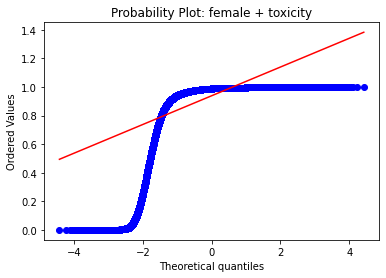

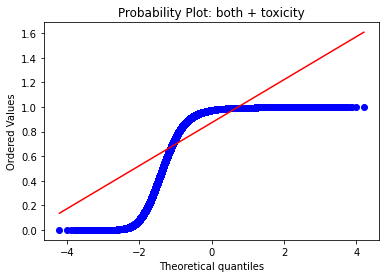

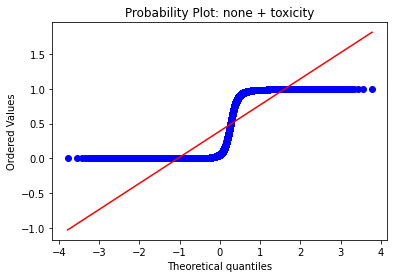

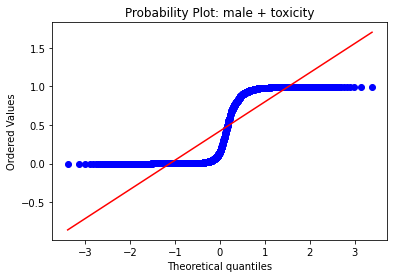

'severe_toxicity'

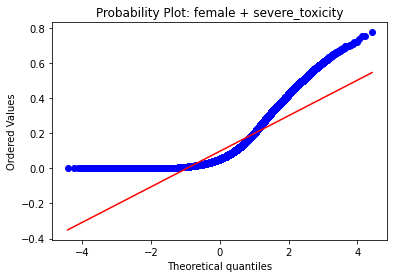

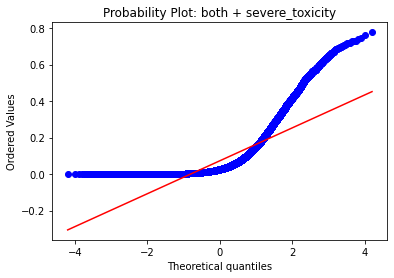

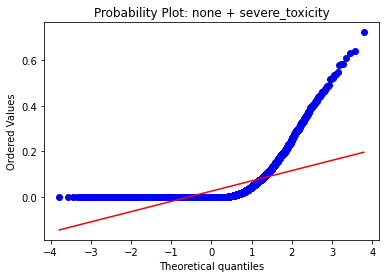

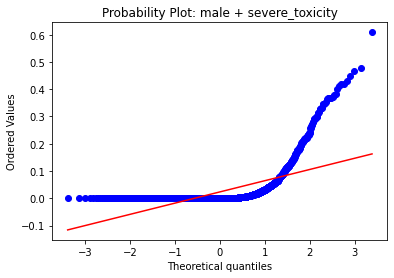

'obscene'

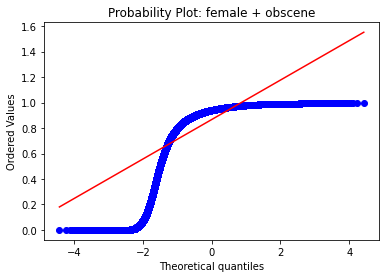

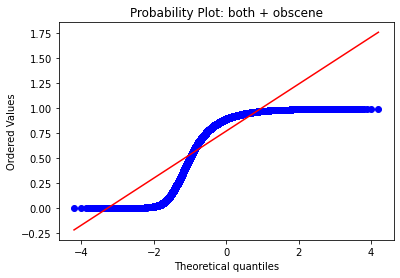

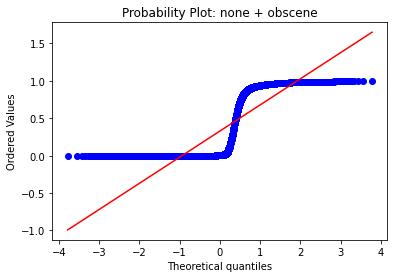

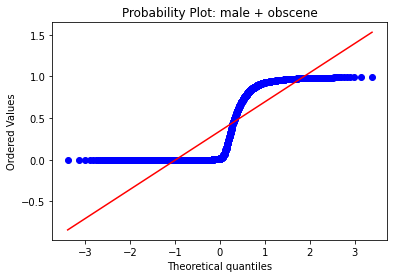

'identity_attack'

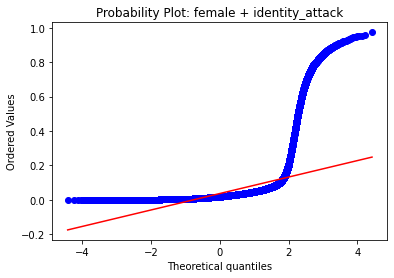

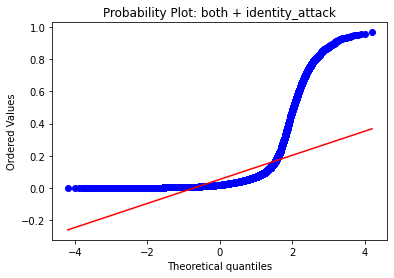

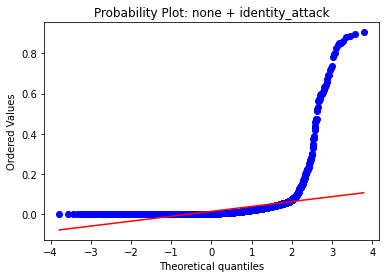

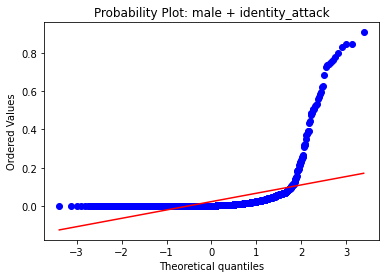

'insult'

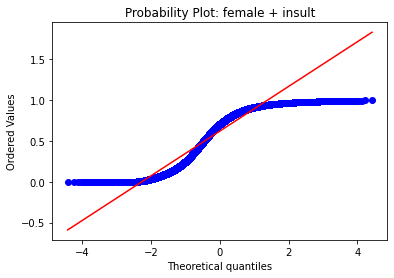

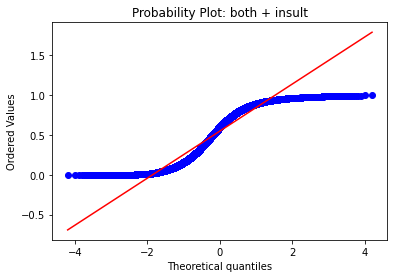

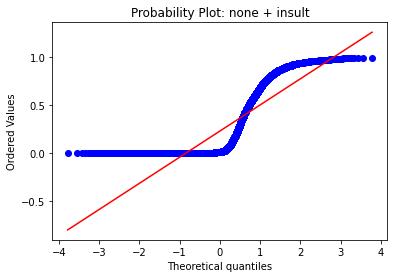

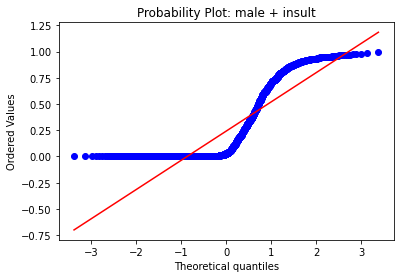

'threat'

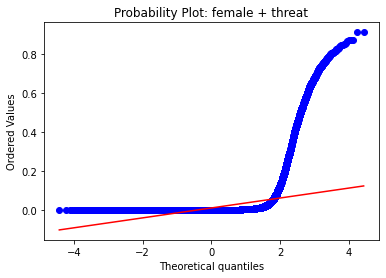

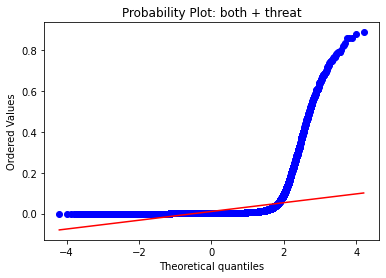

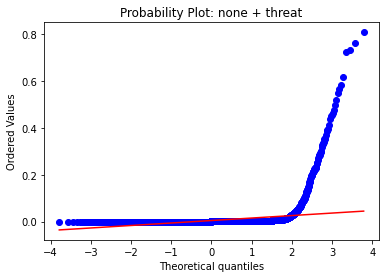

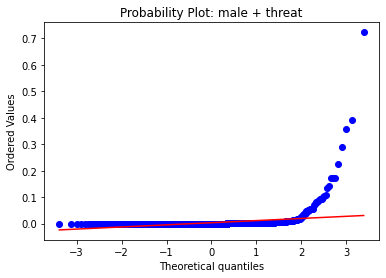

'sexual_explicit'

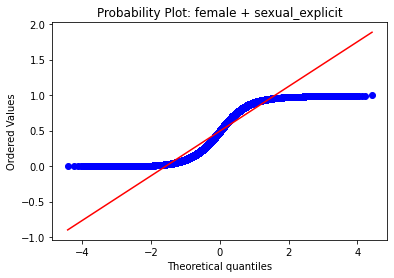

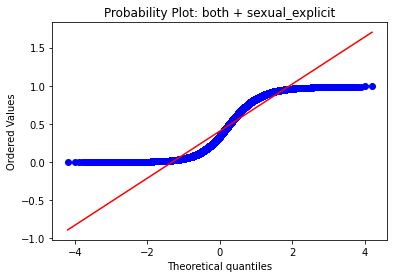

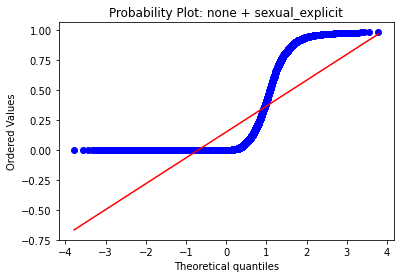

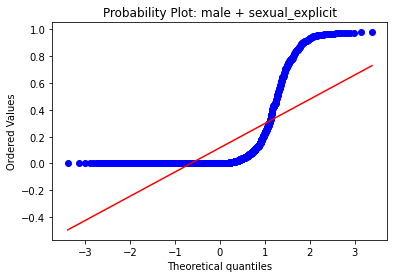

In [24]:
unique_genders = comments['gender'].unique()

detoxify_measures = ['toxicity', 'severe_toxicity', 'obscene',
                    'identity_attack', 'insult', 'threat',
                    'sexual_explicit']

for measure in detoxify_measures:
    display(measure)
    for gender in unique_genders:
        stats.probplot(comments[comments['gender'] == gender][measure], dist="norm", plot=plt)
        plt.title("Probability Plot: " +  gender + ' + ' + measure)
        plt.show()

#### The data is not normally distributed. Parametric tests cannot be used.

The assumptions for ANOVA tests are:
* Data are randomly selected from the population and are independent from other observations.
* Data is normally distributed.
* Homogeneity of variance exists.

The normal probability plots (Q-Q plots) show that the measures are not normally distributed thus ANOVA is not an appropriate test. Normally distributed data show values that are very close to the red diagonal lines.

Krukal-Wallis test is the appropriate method for analyzing this non-parametric data.

In [25]:

for measure in detoxify_measures:
    display(measure)

    both_group = comments[comments['gender'] == 'both'][measure].tolist()
    female_group = comments[comments['gender'] == 'female'][measure].tolist()
    male_group = comments[comments['gender'] == 'male'][measure].tolist()
    none_group = comments[comments['gender'] == 'none'][measure].tolist()

    #display(both_group[0:10])

    #Kruskal-Wallis test

    H, p = stats.kruskal(both_group, female_group, male_group, none_group)

    display(f'Kruskal-Wallis test for {measure}: p = {p}')
    if p <= 0.05:
        display(f'significant: median of {measure} varies by gender groups')
    else:
        display(f'not significant: median of {measure} does not vary by gender groups')


'toxicity'

'Kruskal-Wallis test for toxicity: p = 0.0'

'significant: median of toxicity varies by gender groups'

'severe_toxicity'

'Kruskal-Wallis test for severe_toxicity: p = 0.0'

'significant: median of severe_toxicity varies by gender groups'

'obscene'

'Kruskal-Wallis test for obscene: p = 0.0'

'significant: median of obscene varies by gender groups'

'identity_attack'

'Kruskal-Wallis test for identity_attack: p = 0.0'

'significant: median of identity_attack varies by gender groups'

'insult'

'Kruskal-Wallis test for insult: p = 0.0'

'significant: median of insult varies by gender groups'

'threat'

'Kruskal-Wallis test for threat: p = 0.0'

'significant: median of threat varies by gender groups'

'sexual_explicit'

'Kruskal-Wallis test for sexual_explicit: p = 0.0'

'significant: median of sexual_explicit varies by gender groups'

#### Mann-Whitney post hoc tests

In [26]:
# Mann-Whitney post-hoc test

def mann_whitney_post_hoc():

    groups = [both_group, female_group, male_group, none_group]

    # Bonferroni Adjustment for alpha = alpha/ # comparisons

    n = len(groups)   # number elements
    r = 2  # compare 2 at a time
    num_comparisons = math.factorial(n) / (math.factorial(r) * math.factorial(n-r))

    alpha = 0.05
    Bonferroni = alpha/num_comparisons
    display(f'Bonferroni Adjustment: {Bonferroni}')

    
    mw_results = []

    for measure in detoxify_measures:
        for group1 in groups:
            for group2 in groups:

                # confirmed that groups are being compared correctl
                # display('new comparison',group1[0:5])
                # display(group2[0:5])

                if group1 == group2:
                    result = np.NaN
                else:
                    U, p = mannwhitneyu(group1, group2, method = 'asymptotic') # , axis = 1)
                    
                    if p <= Bonferroni:
                        result = (p, 'significant') 
                    else:
                        result = (p, 'not significant')
                mw_results.append(result)

        # display results

        display(f'post hoc results for {measure}')

        # break results list into lists for each gender option ('both', 'female', 'male', 'neither')
        chunk_size = 4
        chunked_list = [mw_results[i:i+chunk_size] for i in range(0, len(mw_results), chunk_size)]

        df_groups = pd.DataFrame(columns = {'gender': ['both', 'female', 
            'male', 'none'], 'both':np.nan, 'female':np.nan, 
            'male':np.nan, 'none':np.nan})
        df_groups['gender'] = ['both', 'female', 'male', 'none']

        df_groups['both'] = chunked_list[0]
        df_groups['female'] = chunked_list[1]
        df_groups['male'] = chunked_list[2]
        df_groups['none'] = chunked_list[3]

        display(df_groups)




In [27]:
post_hoc = mann_whitney_post_hoc()


'Bonferroni Adjustment: 0.008333333333333333'

'post hoc results for toxicity'

,gender,both,female,male,none
0,both,NaN,"(0.0, significant)","(0.0, significant)","(0.0, significant)"
1,female,"(0.0, significant)",NaN,"(0.0, significant)","(0.0, significant)"
2,male,"(0.0, significant)","(0.0, significant)",NaN,"(0.11059006654613203, not significant)"
3,none,"(0.0, significant)","(0.0, significant)","(0.11059006654613203, not significant)",NaN


'post hoc results for severe_toxicity'

,gender,both,female,male,none
0,both,NaN,"(0.0, significant)","(0.0, significant)","(0.0, significant)"
1,female,"(0.0, significant)",NaN,"(0.0, significant)","(0.0, significant)"
2,male,"(0.0, significant)","(0.0, significant)",NaN,"(0.11059006654613203, not significant)"
3,none,"(0.0, significant)","(0.0, significant)","(0.11059006654613203, not significant)",NaN


'post hoc results for obscene'

,gender,both,female,male,none
0,both,NaN,"(0.0, significant)","(0.0, significant)","(0.0, significant)"
1,female,"(0.0, significant)",NaN,"(0.0, significant)","(0.0, significant)"
2,male,"(0.0, significant)","(0.0, significant)",NaN,"(0.11059006654613203, not significant)"
3,none,"(0.0, significant)","(0.0, significant)","(0.11059006654613203, not significant)",NaN


'post hoc results for identity_attack'

,gender,both,female,male,none
0,both,NaN,"(0.0, significant)","(0.0, significant)","(0.0, significant)"
1,female,"(0.0, significant)",NaN,"(0.0, significant)","(0.0, significant)"
2,male,"(0.0, significant)","(0.0, significant)",NaN,"(0.11059006654613203, not significant)"
3,none,"(0.0, significant)","(0.0, significant)","(0.11059006654613203, not significant)",NaN


'post hoc results for insult'

,gender,both,female,male,none
0,both,NaN,"(0.0, significant)","(0.0, significant)","(0.0, significant)"
1,female,"(0.0, significant)",NaN,"(0.0, significant)","(0.0, significant)"
2,male,"(0.0, significant)","(0.0, significant)",NaN,"(0.11059006654613203, not significant)"
3,none,"(0.0, significant)","(0.0, significant)","(0.11059006654613203, not significant)",NaN


'post hoc results for threat'

,gender,both,female,male,none
0,both,NaN,"(0.0, significant)","(0.0, significant)","(0.0, significant)"
1,female,"(0.0, significant)",NaN,"(0.0, significant)","(0.0, significant)"
2,male,"(0.0, significant)","(0.0, significant)",NaN,"(0.11059006654613203, not significant)"
3,none,"(0.0, significant)","(0.0, significant)","(0.11059006654613203, not significant)",NaN


'post hoc results for sexual_explicit'

,gender,both,female,male,none
0,both,NaN,"(0.0, significant)","(0.0, significant)","(0.0, significant)"
1,female,"(0.0, significant)",NaN,"(0.0, significant)","(0.0, significant)"
2,male,"(0.0, significant)","(0.0, significant)",NaN,"(0.11059006654613203, not significant)"
3,none,"(0.0, significant)","(0.0, significant)","(0.11059006654613203, not significant)",NaN


## Question 17

Do the Detoxify scores differ based on the hate/offensive/neither classifications of the comments?

#### Operationalized Question
What are the relationships between Detoxify scores and hate, offensive, toxic (hate + offensive) and neither classifications?

method: Since the data is non-parametric, ANOVA is not appropriate. The data was analyzed with Kruskal-Wallis tests followed by Mann-Whitney post-hoc tests.

#### Hypotheses
The Detoxify scores will be lower for the neither classification than for the hate or offensive classifications.

Detoxify scores will not be significantly different between the hate and offensive comments.

* H0: Median detoxify measures are equal across the language groups.
* H1: Median detoxify measures are not equal across the language groups.


#### Results
For all toxicity measures (toxicity, severe_toxicity, obscene, identity attack, insult, threat, and sexual_explicit), the hate, offensive, and neither categories are significantly (p < 0.001) different. The toxic category, a combination of hate and offensive speech, was not significantly different from the hate or offensive categories.

For most Detoxify measures -- toxicity, severe_toxicity, obscene, and threat -- the scores decline from hate to offensive to neither, showing that the Davidson labels and the Detoxify scores are aligned.

The Detoxify score sexual_explicit is highest for comments categorized as offensive followed by those identified as hate and then neither. The Davidson categorization scheme is more likely to consider comments with high sexual_explicit scores as offensive (median = 0.645) rather than hate (median = 0.447) or neither (median = 0.226). 

The  Detoxify measures identity attack and insult are significantly higher for hate, but then the neither category is higher than the offensive category.


In [29]:
# make df of median Detoxify scores grouped by Davidson labels

# calculate medians by Davidson label groups (toxic (hate + offensive), hate, offensive, neither)
davidson_median_df = comments.groupby('davidson_label').median().reset_index()
davidson_median_df = davidson_median_df.drop(['score', 'author_premium', 'controversiality', 'created_utc', 'is_submitter', 'retrieved_utc','davidson_label'], axis = 1)
davidson_median_df.insert(0, 'lang_class', ['hate', 'offensive', 'neither'])
display(davidson_median_df)

# uncomment to write to .csv
davidson_median_df.to_csv('../data/viz/RQ17_davidson_median.csv', index = False)

,lang_class,toxicity,severe_toxicity,obscene,identity_attack,insult,threat,sexual_explicit
0,hate,0.994238,0.112448,0.961848,0.031694,0.844437,0.002291,0.447356
1,offensive,0.983430,0.042694,0.930737,0.014861,0.563637,0.001499,0.645070
2,neither,0.979467,0.024865,0.902336,0.016101,0.622403,0.000970,0.225556


In [30]:
lang_classes = ['hate', 'offensive', 'neither']

toxicity_chart = alt.Chart(davidson_median_df).mark_bar().encode(
    x = alt.X('lang_class:N', sort = lang_classes),
    y = alt.Y('toxicity:Q')
    ).properties(title = 'Toxicity').properties(width = 80, height = 100)

severe_toxicity_chart = alt.Chart(davidson_median_df).mark_bar().encode(
    x = alt.X('lang_class:N', sort = lang_classes),
    y = alt.Y('severe_toxicity:Q')
    ).properties(title = 'Severe Toxicity').properties(width = 80, height = 100)

obscene_chart = alt.Chart(davidson_median_df).mark_bar().encode(
    x = alt.X('lang_class:N', sort = lang_classes),
    y = alt.Y('obscene:Q')
    ).properties(title = 'Obscene').properties(width = 80, height = 100)

identity_attack_chart = alt.Chart(davidson_median_df).mark_bar().encode(
    x = alt.X('lang_class:N', sort = lang_classes),
    y = alt.Y('identity_attack:Q')
    ).properties(title = 'Identity Attack').properties(width = 80, height = 100)

insult_chart = alt.Chart(davidson_median_df).mark_bar().encode(
    x = alt.X('lang_class:N', sort = lang_classes),
    y = alt.Y('insult:Q')
    ).properties(title = 'Insult').properties(width = 80, height = 100)

threat_chart = alt.Chart(davidson_median_df).mark_bar().encode(
    x = alt.X('lang_class:N', sort = lang_classes),
    y = alt.Y('threat:Q')
    ).properties(title = 'Threat').properties(width = 80, height = 100)

sexual_explicit_chart = alt.Chart(davidson_median_df).mark_bar().encode(
    x = alt.X('lang_class:N', sort = lang_classes),
    y = alt.Y('sexual_explicit:Q')
    ).properties(title = 'Sexual Explicit').properties(width = 80, height = 100)

#display(toxicity_chart)

top = toxicity_chart | severe_toxicity_chart | obscene_chart | identity_attack_chart
bottom = insult_chart | threat_chart | sexual_explicit_chart 

combined = top & bottom

display(combined)

alt.VConcatChart(...)

'toxicity'

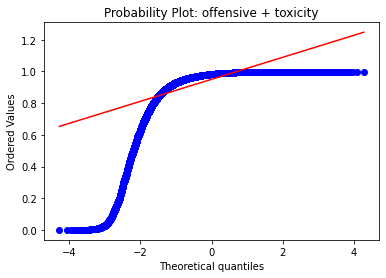

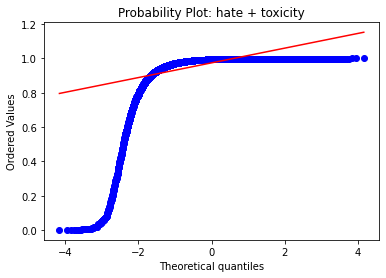

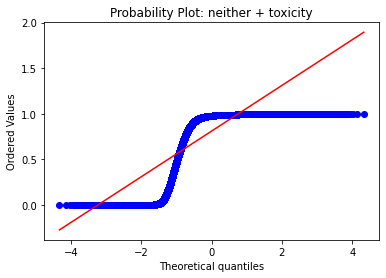

'severe_toxicity'

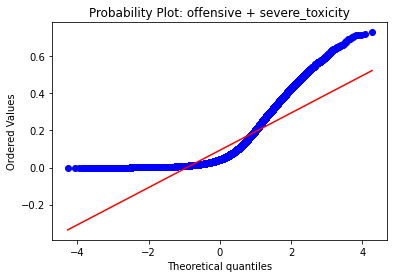

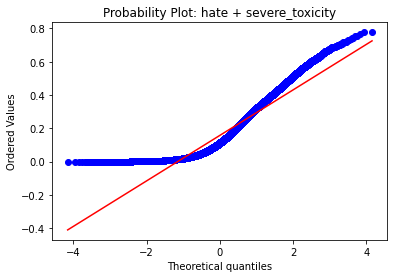

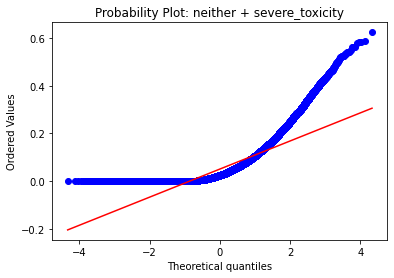

'obscene'

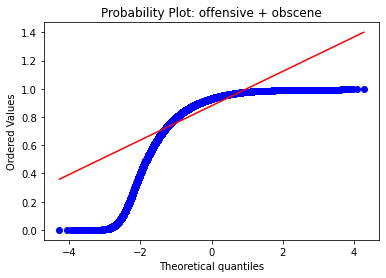

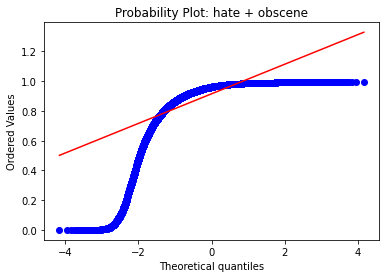

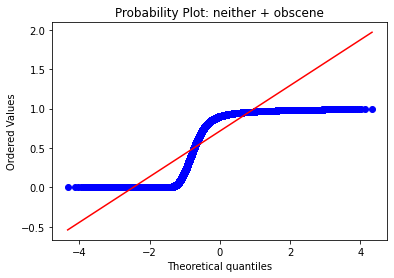

'identity_attack'

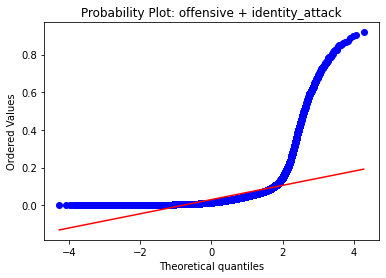

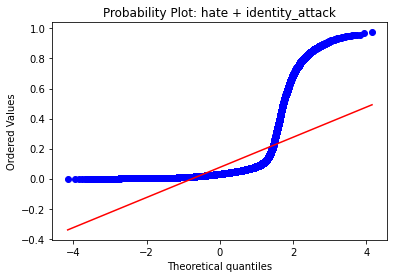

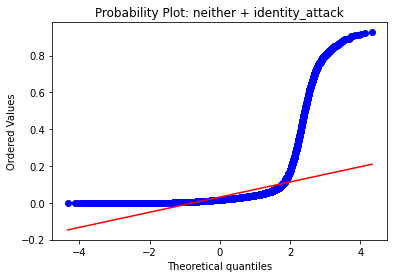

'insult'

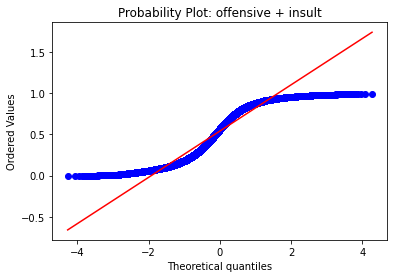

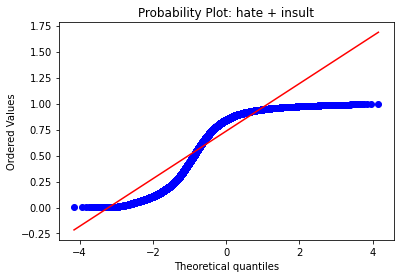

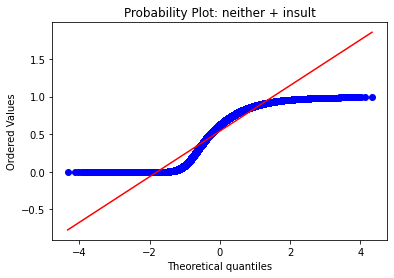

'threat'

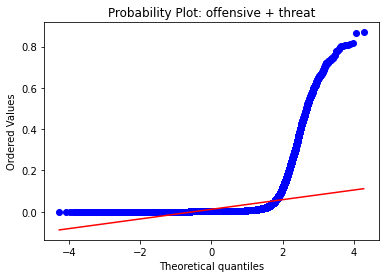

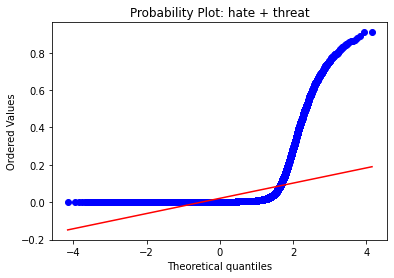

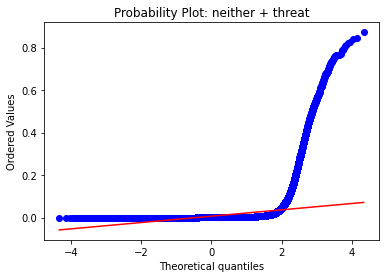

'sexual_explicit'

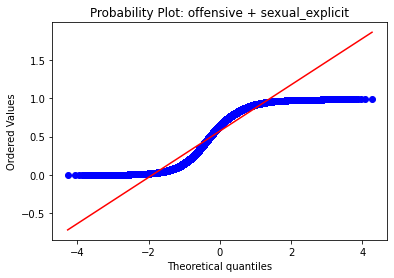

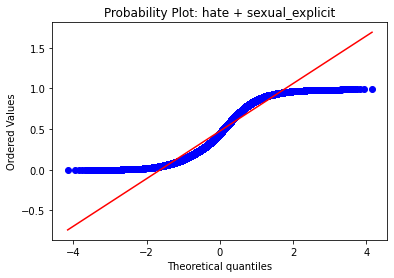

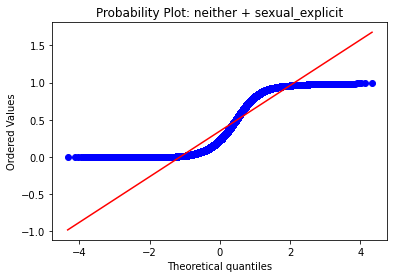

In [31]:
unique_groups = comments['davidson_label'].unique()

detoxify_measures = ['toxicity', 'severe_toxicity', 'obscene',
                    'identity_attack', 'insult', 'threat',
                    'sexual_explicit']

for measure in detoxify_measures:
    display(measure)
    for group in unique_groups:
        stats.probplot(comments[comments['davidson_label'] == group][measure], dist="norm", plot=plt)
        
        if group == 0:
            group_name = 'hate'
        if group == 1:
            group_name = 'offensive'
        if group == 2:
            group_name = 'neither'
        
        plt.title('Probability Plot: ' +  group_name + ' + ' + measure)
        plt.show()

The assumptions for ANOVA tests are:
* Data are randomly selected from the population and are independent from other observations.
* Data is normally distributed.
* Homogeneity of variance exists.

The normal probability plots (Q-Q plots) show that the measures are not normally distributed thus ANOVA is not an appropriate test. Normally distributed data show values that are very close to the red diagonal lines.

Krukall-Wallis tesst is the appropriate method for analyzing this non-parametric data.

In [32]:
for measure in detoxify_measures:
    display(measure)

    hate_group = comments[comments['davidson_label'] == 0][measure].tolist()
    offensive_group = comments[comments['davidson_label'] == 1][measure].tolist()
    toxic_group = comments[(comments['davidson_label'] == 0)|(comments['davidson_label'] == 1)][measure].tolist()
    neither_group = comments[comments['davidson_label'] == 2][measure].tolist()

    #display(neither_group[0:5])

    #Kruskal-Wallis test

    H, p = stats.kruskal(hate_group, offensive_group, toxic_group, neither_group)

    display(f'Kruskal-Wallis test for {measure}: p = {p}')
    if p <= 0.05:
        display(f'significant: median of {measure} varies by Davidson classification groups')
    else:
        display(f'not significant: median of {measure} does not vary by Davidson classification groups')

'toxicity'

'Kruskal-Wallis test for toxicity: p = 0.0'

'significant: median of toxicity varies by Davidson classification groups'

'severe_toxicity'

'Kruskal-Wallis test for severe_toxicity: p = 0.0'

'significant: median of severe_toxicity varies by Davidson classification groups'

'obscene'

'Kruskal-Wallis test for obscene: p = 0.0'

'significant: median of obscene varies by Davidson classification groups'

'identity_attack'

'Kruskal-Wallis test for identity_attack: p = 0.0'

'significant: median of identity_attack varies by Davidson classification groups'

'insult'

'Kruskal-Wallis test for insult: p = 0.0'

'significant: median of insult varies by Davidson classification groups'

'threat'

'Kruskal-Wallis test for threat: p = 0.0'

'significant: median of threat varies by Davidson classification groups'

'sexual_explicit'

'Kruskal-Wallis test for sexual_explicit: p = 0.0'

'significant: median of sexual_explicit varies by Davidson classification groups'

In [33]:
# Mann-Whitney post-hoc test

def mann_whitney_post_hoc():

    groups = [hate_group, offensive_group, toxic_group, neither_group]

    # Bonferroni Adjustment for alpha = alpha/ # comparisons

    n = len(groups)   # number elements
    r = 2  # compare 2 at a time
    num_comparisons = math.factorial(n) / (math.factorial(r) * math.factorial(n-r))

    alpha = 0.05
    Bonferroni = alpha/num_comparisons
    display(f'Bonferroni Adjustment: {Bonferroni}')

    
    mw_results = []

    for measure in detoxify_measures:
        
        for group1 in groups:
            for group2 in groups:

                # confirmed that groups are being compared correctl
                # display('new comparison',group1[0:5])
                # display(group2[0:5])

                if group1 == group2:
                    result = np.NaN
                else:
                    U, p = mannwhitneyu(group1, group2, method = 'asymptotic') # , axis = 1)
                    
                    if p <= Bonferroni:
                        result = (p, 'significant') 
                    else:
                        result = (p, 'not significant')
                mw_results.append(result)

        # display results

        display(f'post hoc results for {measure}')

        # break results list into lists for each gender option ('both', 'female', 'male', 'neither')
        chunk_size = 4
        chunked_list = [mw_results[i:i+chunk_size] for i in range(0, len(mw_results), chunk_size)]

        df_groups = pd.DataFrame(columns = {'lang_class': ['hate', 'offensive', 
            'toxic', 'neither'], 'hate':np.nan, 'offensive':np.nan, 
            'toxic':np.nan, 'neither':np.nan})
        df_groups['lang_class'] = ['hate', 'offensive', 'toxic', 'neither']

        df_groups['hate'] = chunked_list[0]
        df_groups['offensive'] = chunked_list[1]
        df_groups['toxic'] = chunked_list[2]
        df_groups['neither'] = chunked_list[3]

        display(df_groups)

    

In [34]:
mann_whitney_post_hoc()

'Bonferroni Adjustment: 0.008333333333333333'

'post hoc results for toxicity'

,lang_class,hate,offensive,toxic,neither
0,hate,NaN,"(0.0, significant)","(1.3888732082263017e-256, significant)","(0.0, significant)"
1,offensive,"(0.0, significant)",NaN,"(1.3217988305538577e-129, significant)","(0.0, significant)"
2,toxic,"(1.3888732082263017e-256, significant)","(1.3217988305538577e-129, significant)",NaN,"(0.0, significant)"
3,neither,"(0.0, significant)","(0.0, significant)","(0.0, significant)",NaN


'post hoc results for severe_toxicity'

,lang_class,hate,offensive,toxic,neither
0,hate,NaN,"(0.0, significant)","(1.3888732082263017e-256, significant)","(0.0, significant)"
1,offensive,"(0.0, significant)",NaN,"(1.3217988305538577e-129, significant)","(0.0, significant)"
2,toxic,"(1.3888732082263017e-256, significant)","(1.3217988305538577e-129, significant)",NaN,"(0.0, significant)"
3,neither,"(0.0, significant)","(0.0, significant)","(0.0, significant)",NaN


'post hoc results for obscene'

,lang_class,hate,offensive,toxic,neither
0,hate,NaN,"(0.0, significant)","(1.3888732082263017e-256, significant)","(0.0, significant)"
1,offensive,"(0.0, significant)",NaN,"(1.3217988305538577e-129, significant)","(0.0, significant)"
2,toxic,"(1.3888732082263017e-256, significant)","(1.3217988305538577e-129, significant)",NaN,"(0.0, significant)"
3,neither,"(0.0, significant)","(0.0, significant)","(0.0, significant)",NaN


'post hoc results for identity_attack'

,lang_class,hate,offensive,toxic,neither
0,hate,NaN,"(0.0, significant)","(1.3888732082263017e-256, significant)","(0.0, significant)"
1,offensive,"(0.0, significant)",NaN,"(1.3217988305538577e-129, significant)","(0.0, significant)"
2,toxic,"(1.3888732082263017e-256, significant)","(1.3217988305538577e-129, significant)",NaN,"(0.0, significant)"
3,neither,"(0.0, significant)","(0.0, significant)","(0.0, significant)",NaN


'post hoc results for insult'

,lang_class,hate,offensive,toxic,neither
0,hate,NaN,"(0.0, significant)","(1.3888732082263017e-256, significant)","(0.0, significant)"
1,offensive,"(0.0, significant)",NaN,"(1.3217988305538577e-129, significant)","(0.0, significant)"
2,toxic,"(1.3888732082263017e-256, significant)","(1.3217988305538577e-129, significant)",NaN,"(0.0, significant)"
3,neither,"(0.0, significant)","(0.0, significant)","(0.0, significant)",NaN


'post hoc results for threat'

,lang_class,hate,offensive,toxic,neither
0,hate,NaN,"(0.0, significant)","(1.3888732082263017e-256, significant)","(0.0, significant)"
1,offensive,"(0.0, significant)",NaN,"(1.3217988305538577e-129, significant)","(0.0, significant)"
2,toxic,"(1.3888732082263017e-256, significant)","(1.3217988305538577e-129, significant)",NaN,"(0.0, significant)"
3,neither,"(0.0, significant)","(0.0, significant)","(0.0, significant)",NaN


'post hoc results for sexual_explicit'

,lang_class,hate,offensive,toxic,neither
0,hate,NaN,"(0.0, significant)","(1.3888732082263017e-256, significant)","(0.0, significant)"
1,offensive,"(0.0, significant)",NaN,"(1.3217988305538577e-129, significant)","(0.0, significant)"
2,toxic,"(1.3888732082263017e-256, significant)","(1.3217988305538577e-129, significant)",NaN,"(0.0, significant)"
3,neither,"(0.0, significant)","(0.0, significant)","(0.0, significant)",NaN


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=6bb356e3-2dd8-4635-8ff0-a5ca506d60d1' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>